In [ ]:
!pip install replay-rec[torch] --quiet
!pip install rs_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.8/196.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.5/290.5 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import numpy as np
import pandas as pd

from lightning import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

from replay.data import (Dataset, FeatureHint, FeatureInfo, FeatureSchema,
                         FeatureSource, FeatureType)
from replay.data.nn import (SequenceTokenizer, SequentialDataset,
                            TensorFeatureInfo, TensorFeatureSource,
                            TensorSchema)
from replay.metrics import NDCG, Coverage, Experiment, HitRate, MRR
from replay.metrics.torch_metrics_builder import metrics_to_df
from replay.models.nn.optimizer_utils import FatOptimizerFactory
from replay.models.nn.sequential import Bert4Rec, SasRec
from replay.models.nn.sequential.bert4rec import (Bert4RecPredictionDataset,
                                                  Bert4RecTrainingDataset,
                                                  Bert4RecValidationDataset)
from replay.models.nn.sequential.callbacks import (PandasPredictionCallback,
                                                   ValidationMetricsCallback)
from replay.models.nn.sequential.postprocessors import RemoveSeenItems
from replay.models.nn.sequential.sasrec import (SasRecPredictionDataset,
                                                SasRecTrainingDataset,
                                                SasRecValidationDataset)

from torch.utils.data import DataLoader

## Загрузка данных

Загружаем датасет Movielens-1m с помощью библиотеки rs_datasets.

In [ ]:
from rs_datasets import MovieLens

movielens = MovieLens("1m")
interactions = movielens.ratings
print(interactions.shape)
interactions.head()

INFO:rs_datasets:Downloading ml-1m from grouplens...
5.93MB [00:00, 7.63MB/s]                            


(1000209, 4)


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## Разбиение данных

Сперва разобьем данные на train, validation и test.

Чтобы не было утечки данных и заглядывания в будущее, делаем train-test сплит по времени. Дополнительно от трейна отщепляем часть юзеров для валидации - будем использовать их для расчета метрик в процессе обучения и ранней остановки.

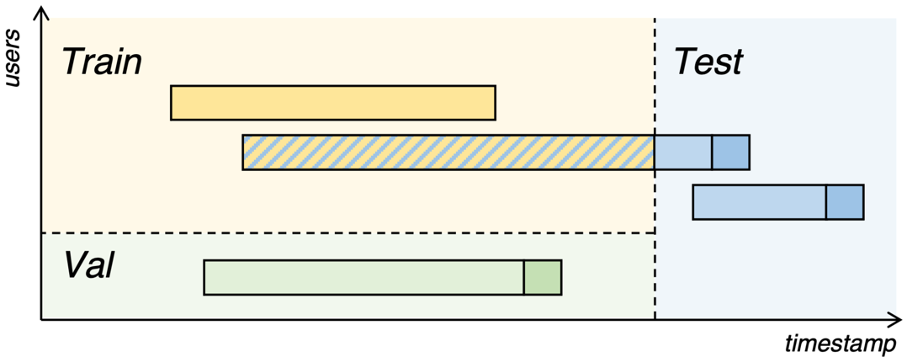

In [ ]:
def make_split(data, time_threshold, validation_size=1000,
               user_id='user_id', timestamp='timestamp', seed=42):
    """Make data splits.
    Train/test split by time, train/validation split by users.
    """

    quantile = data[timestamp].quantile(time_threshold)

    data = data.sort_values([user_id, timestamp])
    user_sequences = data.groupby(user_id)[timestamp].agg(list)

    # to have at least two interactions in train period
    users_train = user_sequences[user_sequences.apply(lambda x: x[1] <= quantile)].index
    # to have last interaction in test period
    users_test = user_sequences[user_sequences.apply(lambda x: x[-1] > quantile)].index

    train = data[data[user_id].isin(users_train)]
    train = train[train[timestamp] <= quantile]
    test = data[data[user_id].isin(users_test)]

    np.random.seed(seed)
    validation_users = np.random.choice(train[user_id].unique(),
                                        size=validation_size, replace=False)
    validation = train[train[user_id].isin(validation_users)]
    train = train[~train[user_id].isin(validation_users)]

    return train, validation, test

In [ ]:
TIME_THRESHOLD = 0.8
VALIDATION_SIZE = 500

raw_train_events, raw_validation, raw_test = make_split(
    interactions, time_threshold=TIME_THRESHOLD, validation_size=VALIDATION_SIZE)

Удалим из теста и валидации айтемы, которых нет в трейне.

In [ ]:
def drop_cold_items(test, train, user_id='user_id', item_id='item_id'):

    # drop cold items
    test = test[test[item_id].isin(train[item_id])]

    # take users with more than one interaction
    user_count = test[user_id].value_counts()
    users = user_count[user_count > 1].index
    test = test[test[user_id].isin(users)]

    return test

In [ ]:
raw_validation = drop_cold_items(raw_validation, raw_train_events)
raw_test = drop_cold_items(raw_test, raw_train_events)

Берем последний айтем в ground truth, на нем будем считать метрики. Всю остальную историю пользователя будем подавать на вход модели для предсказания этого последнего айтема.

In [ ]:
def split_last_item(data, user_id='user_id', item_id='item_id', timestamp='timestamp'):

    data = data.sort_values([user_id, timestamp])

    first_part = data.groupby(user_id)[item_id].agg(list).apply(
        lambda x: x[:-1]).reset_index().explode(item_id)
    first_part[timestamp] = data.groupby(user_id)[timestamp].agg(list).apply(
        lambda x: x[:-1]).reset_index().explode(timestamp)[timestamp]

    last_item = data.groupby(user_id)[item_id].agg(list).apply(lambda x: x[-1]).reset_index()

    return first_part, last_item

In [ ]:
raw_validation_events, raw_validation_gt = split_last_item(raw_validation)
raw_test_events, raw_test_gt = split_last_item(raw_test)

Статистики получившихся данных.

In [ ]:
print('Количество пользователей в train', raw_train_events.user_id.nunique())
print('Количество пользователей в validation', raw_validation_events.user_id.nunique())
print('Количество пользователей в test', raw_test_events.user_id.nunique())

Количество пользователей в train 4900
Количество пользователей в validation 500
Количество пользователей в test 1783


## Создание датасетов

Создаем FeatureSchema с описанием признаков в датасете. Она нужна для создания датасета.

In [ ]:
def prepare_feature_schema(is_ground_truth):

    base_features = FeatureSchema([
        FeatureInfo(column="user_id",
                    feature_hint=FeatureHint.QUERY_ID,
                    feature_type=FeatureType.CATEGORICAL),
        FeatureInfo(column="item_id",
                    feature_hint=FeatureHint.ITEM_ID,
                    feature_type=FeatureType.CATEGORICAL)])

    if is_ground_truth:
        return base_features

    all_features = base_features + FeatureSchema([
        FeatureInfo(column="timestamp",
                    feature_hint=FeatureHint.TIMESTAMP,
                    feature_type=FeatureType.NUMERICAL)])

    return all_features

Создаем датасет для обучающей выборки.

In [ ]:
train_dataset = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=False),
    interactions=raw_train_events)

Создаем два датасета для валидационной части (первый - последовательности, подаваемые на вход модели для предсказания, второй - отложенные айтемы из ground truth).

In [ ]:
validation_dataset = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=False),
    interactions=raw_validation_events)

validation_gt = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=True),
    interactions=raw_validation_gt)

Так же создаем два датасета для тестовой части.

In [ ]:
test_dataset = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=False),
    interactions=raw_test_events)

test_gt = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=True),
    interactions=raw_test_gt)

## Создание sequential датасетов с помощью SequenceTokenizer

Создание tensor schema, содержащей описание признаков в sequential датасете.

In [ ]:

ITEM_FEATURE_NAME = "item_id_seq"

tensor_schema = TensorSchema(
    TensorFeatureInfo(
        name=ITEM_FEATURE_NAME,
        is_seq=True,
        feature_type=FeatureType.CATEGORICAL,
        feature_sources=[TensorFeatureSource(FeatureSource.INTERACTIONS, train_dataset.feature_schema.item_id_column)],
        feature_hint=FeatureHint.ITEM_ID))

SequentialDataset хранит данные в виде последовательностей, отсортированных по времени взаимодействия.

SequenceTokenizer используется для преобразования в этот формат. Кроме того, SequenceTokenizer кодирует все категориальные признаки из исходного датасета и хранит mapping внутри себя.

In [ ]:
tokenizer = SequenceTokenizer(tensor_schema)
tokenizer.fit(train_dataset)
sequential_train_dataset = tokenizer.transform(train_dataset)

tokenizer.query_id_encoder.partial_fit(raw_validation_events)
sequential_validation_dataset = tokenizer.transform(validation_dataset)
sequential_validation_gt = tokenizer.transform(validation_gt)

tokenizer.query_id_encoder.partial_fit(raw_test_events)
sequential_test_dataset = tokenizer.transform(test_dataset)

## Обучение модели SASRec

Создаем даталоадеры.

In [ ]:
BATCH_SIZE = 128
NUM_WORKERS = 4
MAX_SEQ_LEN = 128

train_dataloader = DataLoader(
    dataset=SasRecTrainingDataset(
        sequential_train_dataset,
        max_sequence_length=MAX_SEQ_LEN),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True)

validation_dataloader = DataLoader(
    dataset=SasRecValidationDataset(
        sequential_validation_dataset,
        sequential_validation_gt,
        sequential_train_dataset,
        max_sequence_length=MAX_SEQ_LEN),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Создаем класс модели SASRec.

In [ ]:
BLOCK_COUNT = 2
HEAD_COUNT = 2
HIDDEN_SIZE = 64
DROPOUT_RATE = 0.1

LEARNING_RATE = 0.001

sasrec_model = SasRec(
    tensor_schema,
    block_count=BLOCK_COUNT,
    head_count=HEAD_COUNT,
    max_seq_len=MAX_SEQ_LEN,
    hidden_size=HIDDEN_SIZE,
    dropout_rate=DROPOUT_RATE,
    optimizer_factory=FatOptimizerFactory(learning_rate=LEARNING_RATE))

Создаем callback'и для ранней остановки, загрузки весов модели с лучшей эпохи и для расчета метрик на валидации. Добавляем RemoveSeenItems, чтобы фильтровать из предсказаний айтемы, которые были в истории пользователя.

In [ ]:
PATIENCE = 5
TOP_K = [10]

early_stopping_callback = EarlyStopping(monitor="ndcg@10", patience=PATIENCE, mode='max')
checkpoint_callback = ModelCheckpoint(monitor="ndcg@10", save_top_k=1, mode="max")

validation_metrics_callback = ValidationMetricsCallback(
    metrics=["ndcg"],
    ks=TOP_K,
    item_count=train_dataset.item_count,
    postprocessors=[RemoveSeenItems(sequential_validation_dataset)],)

Создаем Trainer и обучаем модель.

In [ ]:
%%time

MAX_EPOCHS = 30

csv_logger = CSVLogger(save_dir=".logs/", name="SASRec")

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[early_stopping_callback, checkpoint_callback, validation_metrics_callback],
    logger=csv_logger)

trainer.fit(sasrec_model,
            train_dataloaders=train_dataloader,
            val_dataloaders=validation_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type             | Params | Mode 
----------------------------------------------------
0 | _model | SasRecModel      | 292 K  | train
1 | _loss  | CrossEntropyLoss | 0      | train
----------------------------------------------------
292 K     Trainable params
0         Non-trainable params
292 K     Total params
1.169     Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.023249



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.016292



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.038438



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k          10
ndcg  0.06676



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.079319



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.097705



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.095338



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.116537



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.119845



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.117755



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.128642



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.134031



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.137259



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.140268



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.145063



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.139646



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.144458



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.139505



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.143806



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.142367

CPU times: user 25.7 s, sys: 7.34 s, total: 33 s
Wall time: 53.5 s


Смотрим как менялись метрики в зависимости от эпохи.

<Axes: xlabel='epoch'>

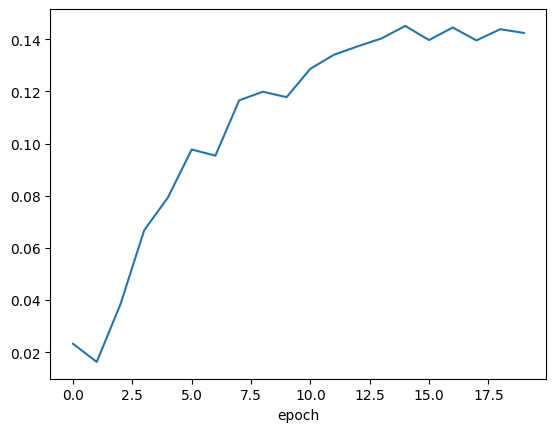

In [ ]:
sasrec_validation_metrics = pd.read_csv(os.path.join(trainer.logger.log_dir, 'metrics.csv'))
sasrec_validation_metrics = sasrec_validation_metrics[sasrec_validation_metrics['ndcg@10'].notnull()]
sasrec_validation_metrics.set_index('epoch')['ndcg@10'].plot()

Загружаем веса модели с лучшей эпохи на валидации.

In [ ]:
sasrec_best_model = SasRec.load_from_checkpoint(checkpoint_callback.best_model_path)

## Предсказание на тесте и расчет метрик

Создаем тестовый даталоадер.

In [ ]:
prediction_dataloader = DataLoader(
    dataset=SasRecPredictionDataset(
        sequential_test_dataset,
        max_sequence_length=MAX_SEQ_LEN),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Делаем предсказания.

In [ ]:
pandas_prediction_callback = PandasPredictionCallback(
    top_k=max(TOP_K),
    query_column="user_id",
    item_column="item_id",
    rating_column="score",
    postprocessors=[RemoveSeenItems(sequential_test_dataset)])

trainer = Trainer(callbacks=[pandas_prediction_callback],
                  inference_mode=True)
trainer.predict(sasrec_best_model, dataloaders=prediction_dataloader, return_predictions=False)

preds = pandas_prediction_callback.get_result()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Не забываем сделать обратное преобразование закодированных user_id и item_id.

In [ ]:
sasrec_recommendations = tokenizer.query_and_item_id_encoder.inverse_transform(preds)

In [ ]:
sasrec_recommendations

,user_id,item_id,score
0,635,1963,5.778271
0,635,915,5.523943
0,635,1028,5.248623
0,635,2946,5.174039
0,635,2863,4.816092
...,...,...,...
1782,1877,2908,4.396303
1782,1877,3915,4.297172
1782,1877,3895,4.199891
1782,1877,3909,4.184766


Считаем метрики.

In [ ]:
ex = Experiment([NDCG(TOP_K), MRR(TOP_K), HitRate(TOP_K), Coverage(TOP_K)],
                raw_test_gt, raw_train_events,
                query_column='user_id', rating_column='score')

ex.add_result("SASRec", sasrec_recommendations)
ex.results

/usr/local/lib/python3.10/dist-packages/replay/metrics/offline_metrics.py:375: UserWarning: train contains queries that are not presented in recommendations
  warnings.warn(f"{dataset_name} contains queries that are not presented in recommendations")


,NDCG@10,MRR@10,HitRate@10,Coverage@10
SASRec,0.08212,0.058765,0.159282,0.470266


## Bert4Rec

Обучаем модель.

In [ ]:
%%time

train_dataloader = DataLoader(
    dataset=Bert4RecTrainingDataset(
        sequential_train_dataset,
        max_sequence_length=MAX_SEQ_LEN),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True)

validation_dataloader = DataLoader(
    dataset=Bert4RecValidationDataset(
        sequential_validation_dataset,
        sequential_validation_gt,
        sequential_train_dataset,
        max_sequence_length=MAX_SEQ_LEN),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS)

bert4rec_model = Bert4Rec(
    tensor_schema,
    block_count=BLOCK_COUNT,
    head_count=HEAD_COUNT,
    max_seq_len=MAX_SEQ_LEN,
    hidden_size=HIDDEN_SIZE,
    dropout_rate=DROPOUT_RATE,
    optimizer_factory=FatOptimizerFactory(learning_rate=LEARNING_RATE))

early_stopping_callback = EarlyStopping(monitor="ndcg@10", patience=PATIENCE, mode='max')
checkpoint_callback = ModelCheckpoint(monitor="ndcg@10", save_top_k=1, mode="max")

validation_metrics_callback = ValidationMetricsCallback(
    metrics=["ndcg"],
    ks=TOP_K,
    item_count=train_dataset.item_count,
    postprocessors=[RemoveSeenItems(sequential_validation_dataset)])

csv_logger = CSVLogger(save_dir=".logs/", name="BERT4Rec")

trainer = Trainer(
    max_epochs=MAX_EPOCHS, logger=csv_logger,
    callbacks=[checkpoint_callback, early_stopping_callback, validation_metrics_callback])

trainer.fit(bert4rec_model,
            train_dataloaders=train_dataloader,
            val_dataloaders=validation_dataloader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.010798



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.013279



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.017547



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.015165



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.034276



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k          10
ndcg  0.02048



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.020891



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.029677



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.030766



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k          10
ndcg  0.04255



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.033217



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.048487



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.057863



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.056842



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.057093



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.069925



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.069768



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.081736



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.079686



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k          10
ndcg  0.09617



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.083445



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.094838



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.092016



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.109942



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k          10
ndcg  0.09773



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.099959



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.099832



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.111359



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k           10
ndcg  0.093267



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


k           10
ndcg  0.101317

CPU times: user 48 s, sys: 12.7 s, total: 1min
Wall time: 1min 38s


Смотрим как менялись метрики в зависимости от эпохи.

<Axes: xlabel='epoch'>

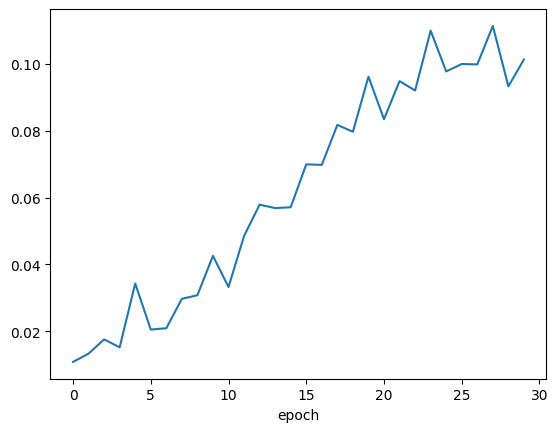

In [ ]:
bert4rec_validation_metrics = pd.read_csv(os.path.join(trainer.logger.log_dir, 'metrics.csv'))
bert4rec_validation_metrics = bert4rec_validation_metrics[bert4rec_validation_metrics['ndcg@10'].notnull()]
bert4rec_validation_metrics.set_index('epoch')['ndcg@10'].plot()

Делаем предсказания.

In [ ]:
bert4rec_best_model = Bert4Rec.load_from_checkpoint(checkpoint_callback.best_model_path)

prediction_dataloader = DataLoader(
    dataset=Bert4RecPredictionDataset(
        sequential_test_dataset,
        max_sequence_length=MAX_SEQ_LEN),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS)

pandas_prediction_callback = PandasPredictionCallback(
    top_k=max(TOP_K),
    query_column="user_id",
    item_column="item_id",
    rating_column="score",
    postprocessors=[RemoveSeenItems(sequential_test_dataset)])

trainer = Trainer(callbacks=[pandas_prediction_callback],
                  inference_mode=True)
trainer.predict(bert4rec_best_model, dataloaders=prediction_dataloader, return_predictions=False)

preds = pandas_prediction_callback.get_result()
bert4rec_recommendations = tokenizer.query_and_item_id_encoder.inverse_transform(preds)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Считаем метрики.

In [ ]:
ex.add_result("BERT4Rec", bert4rec_recommendations)
ex.results

/usr/local/lib/python3.10/dist-packages/replay/metrics/offline_metrics.py:375: UserWarning: train contains queries that are not presented in recommendations
  warnings.warn(f"{dataset_name} contains queries that are not presented in recommendations")


,NDCG@10,MRR@10,HitRate@10,Coverage@10
SASRec,0.082120,0.058765,0.159282,0.470266
BERT4Rec,0.070341,0.052647,0.128996,0.362017


## Семплирование негативных примеров в функции потерь

Обучаем модель.

In [ ]:
LOSS_SAMPLE_COUNT = 100

In [ ]:
%%time

train_dataloader = DataLoader(
    dataset=SasRecTrainingDataset(
        sequential_train_dataset,
        max_sequence_length=MAX_SEQ_LEN),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True)

validation_dataloader = DataLoader(
    dataset=SasRecValidationDataset(
        sequential_validation_dataset,
        sequential_validation_gt,
        sequential_train_dataset,
        max_sequence_length=MAX_SEQ_LEN),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS)

sasrec_model_sampled = SasRec(
    tensor_schema,
    block_count=BLOCK_COUNT,
    head_count=HEAD_COUNT,
    max_seq_len=MAX_SEQ_LEN,
    hidden_size=HIDDEN_SIZE,
    dropout_rate=DROPOUT_RATE,
    optimizer_factory=FatOptimizerFactory(learning_rate=LEARNING_RATE),
    loss_sample_count=LOSS_SAMPLE_COUNT)

early_stopping_callback = EarlyStopping(monitor="ndcg@10", patience=PATIENCE, mode='max')
checkpoint_callback = ModelCheckpoint(monitor="ndcg@10", save_top_k=1, mode="max")

csv_logger = CSVLogger(save_dir=".logs/", name="SASRec_sampled")

validation_metrics_callback = ValidationMetricsCallback(
    metrics=["ndcg", "mrr", "recall"],
    ks=TOP_K,
    item_count=train_dataset.item_count,
    postprocessors=[RemoveSeenItems(sequential_validation_dataset)])

trainer = Trainer(
    max_epochs=MAX_EPOCHS, logger=csv_logger,
    callbacks=[checkpoint_callback, early_stopping_callback, validation_metrics_callback])

trainer.fit(sasrec_model_sampled,
            train_dataloaders=train_dataloader,
            val_dataloaders=validation_dataloader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.011508
ndcg    0.016351
recall  0.032000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.012839
ndcg    0.018553
recall  0.038000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.025794
ndcg    0.037063
recall  0.074000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.046715
ndcg    0.062786
recall  0.116000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.060621
ndcg    0.081639
recall  0.150000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.075363
ndcg    0.101106
recall  0.186000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.078637
ndcg    0.107816
recall  0.204000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.087872
ndcg    0.116269
recall  0.210000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.087285
ndcg    0.117025
recall  0.216000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.092967
ndcg    0.124623
recall  0.230000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.093345
ndcg    0.126389
recall  0.236000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.096427
ndcg    0.133330
recall  0.256000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.100376
ndcg    0.137831
recall  0.262000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.093479
ndcg    0.130739
recall  0.254000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.100508
ndcg    0.139387
recall  0.268000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.101892
ndcg    0.142555
recall  0.278000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.099279
ndcg    0.137506
recall  0.264000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.099479
ndcg    0.139549
recall  0.272000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.099721
ndcg    0.139829
recall  0.272000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.098919
ndcg    0.137308
recall  0.264000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

k             10
mrr     0.098449
ndcg    0.136635
recall  0.262000

CPU times: user 28.7 s, sys: 9.83 s, total: 38.5 s
Wall time: 1min


In [ ]:
sasrec_sampled_validation_metrics = pd.read_csv(os.path.join(trainer.logger.log_dir, 'metrics.csv'))
sasrec_sampled_validation_metrics = sasrec_sampled_validation_metrics[sasrec_sampled_validation_metrics['ndcg@10'].notnull()]

Сравним историю обучения разных моделей.

<Axes: xlabel='epoch'>

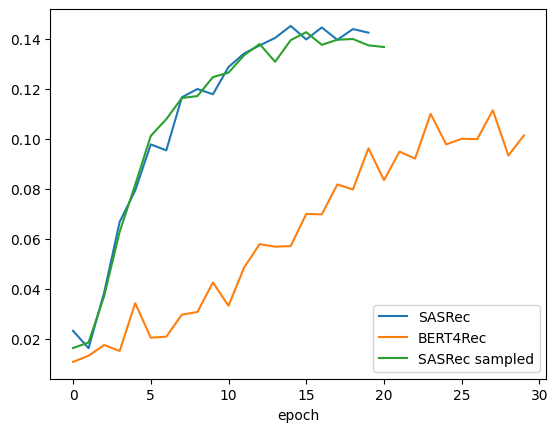

In [ ]:
validation_metrics = sasrec_validation_metrics.set_index('epoch')['ndcg@10'].rename('SASRec').to_frame()
validation_metrics = validation_metrics.join(
    bert4rec_validation_metrics.set_index('epoch')['ndcg@10'].rename('BERT4Rec'),
    how='outer')
validation_metrics = validation_metrics.join(
    sasrec_sampled_validation_metrics.set_index('epoch')['ndcg@10'].rename('SASRec sampled'),
    how='outer')

validation_metrics.plot()

Делаем предсказания.

In [ ]:
sasrec_best_model_sampled = SasRec.load_from_checkpoint(checkpoint_callback.best_model_path)

prediction_dataloader = DataLoader(
    dataset=SasRecPredictionDataset(
        sequential_test_dataset,
        max_sequence_length=MAX_SEQ_LEN),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS)

pandas_prediction_callback = PandasPredictionCallback(
    top_k=max(TOP_K),
    query_column="user_id",
    item_column="item_id",
    rating_column="score",
    postprocessors=[RemoveSeenItems(sequential_test_dataset)])

trainer = Trainer(callbacks=[pandas_prediction_callback],
                  inference_mode=True)
trainer.predict(sasrec_best_model_sampled, dataloaders=prediction_dataloader, return_predictions=False)

preds = pandas_prediction_callback.get_result()
sasrec_sampled_recommendations = tokenizer.query_and_item_id_encoder.inverse_transform(preds)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Считаем метрики.

In [ ]:
ex.add_result("SASRec sampled", sasrec_sampled_recommendations)
ex.results

/usr/local/lib/python3.10/dist-packages/replay/metrics/offline_metrics.py:375: UserWarning: train contains queries that are not presented in recommendations
  warnings.warn(f"{dataset_name} contains queries that are not presented in recommendations")


,NDCG@10,MRR@10,HitRate@10,Coverage@10
SASRec,0.082120,0.058765,0.159282,0.470266
BERT4Rec,0.070341,0.052647,0.128996,0.362017
SASRec sampled,0.083602,0.059939,0.162086,0.434640
